Demo #2: Forecasting(no LSTM component). \
\
NOTE: \
No data standardization, no training model

Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

Import components

In [2]:
from canari import (
    DataProcess,
    Model,
    plot_data,
    plot_prediction,
    plot_states,
)
from canari.component import LocalTrend, Periodic, WhiteNoise

/opt/miniconda3/envs/canari/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-07 14:54:45,810	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-07 14:54:45,887	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Read data

In [3]:
project_root = Path.cwd().resolve().parents[1]
data_file = str(project_root / "data" / "benchmark_data" / "test_4_data.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
time = pd.to_datetime(df.iloc[:, 0])
df = df.iloc[:, [1]]
df.index = time
df.index.name = "time"
df.columns = ["crack opening"]
df.head()

,crack opening
time,
2010-11-07,6.595455
2010-11-14,6.523333
2010-11-21,6.430000
2010-11-28,6.360000
2010-12-05,6.210000


Data preprocess

In [4]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    train_split=0.4,
    validation_split=0.07,
    output_col=output_col,
    standardization=False,
)
train_data, validation_data, test_data, standardized_data = data_processor.get_splits()

Define model from components

In [5]:
local_trend = LocalTrend()
pattern = Periodic(period=52)
residual = WhiteNoise(std_error=0.04168)

model = Model(local_trend, pattern, residual)

1A. Initial values for hidden states: default

In [6]:
print(f"Inital mean for hidden states : \n{model.mu_states}")
print(f"Inital variance for hidden states : \n{model.var_states}")

Inital mean for hidden states : 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Inital variance for hidden states : 
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


1B. Initial values for hidden states: user define -- manual

In [7]:
local_trend = LocalTrend(mu_states=[1,0.5], var_states=[1,0.5])
pattern = Periodic(mu_states=[1,1],var_states=[2,2],period=52)
residual = WhiteNoise(std_error=0.04168)

model = Model(local_trend, pattern, residual)
print(f"Inital mean for hidden states : \n{model.mu_states}")
print(f"Inital variance for hidden states : \n{model.var_states}")

Inital mean for hidden states : 
[[1. ]
 [0.5]
 [1. ]
 [1. ]
 [0. ]]
Inital variance for hidden states : 
[[1.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0. ]
 [0.  0.  2.  0.  0. ]
 [0.  0.  0.  2.  0. ]
 [0.  0.  0.  0.  0. ]]


1C. Initial values for hidden states: user define -- Automatic

In [8]:
local_trend = LocalTrend()
pattern = Periodic(mu_states=[0,0],var_states=[.1,.1],period=52)
residual = WhiteNoise(std_error=0.04168)

model = Model(local_trend, pattern, residual)
model.auto_initialize_baseline_states(train_data["y"][0 : 52 * 3])

print(f"Inital mean for hidden states : \n{model.mu_states}")
print(f"Inital variance for hidden states : \n{model.var_states}")

Inital mean for hidden states : 
[[6.09993578]
 [0.00750979]
 [0.        ]
 [0.        ]
 [0.        ]]
Inital variance for hidden states : 
[[0.01 0.   0.   0.   0.  ]
 [0.   0.01 0.   0.   0.  ]
 [0.   0.   0.1  0.   0.  ]
 [0.   0.   0.   0.1  0.  ]
 [0.   0.   0.   0.   0.  ]]


Analyses:
- Filter:  
- Smoother:      
- Forecast:  

Filter

In [9]:
mu_train_pred, std_train_pred, states=model.filter(data=train_data)

Filter's results

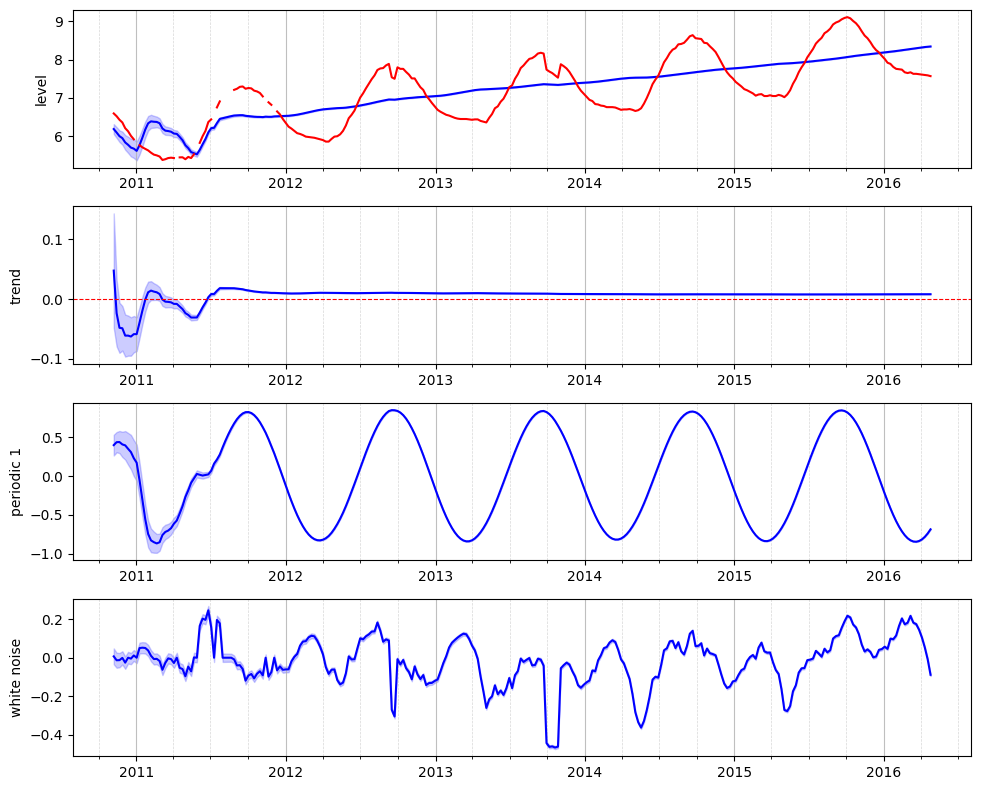

In [10]:
fig, ax =plot_states(data_processor=data_processor,
                     states=states,
                     states_to_plot=["level", "trend","periodic 1", "white noise"])
plot_data(data_processor=data_processor,
          plot_train_data=True,
          plot_test_data=False,
          plot_validation_data=False,
          sub_plot=ax[0])
plt.show()

Smoother

In [11]:
states =model.smoother()

/Users/vuongdai/GitHub/canari/src/canari/data_struct.py:196: RuntimeWarning: invalid value encountered in sqrt
  standard_deviation[state] = values[:, idx, idx] ** 0.5


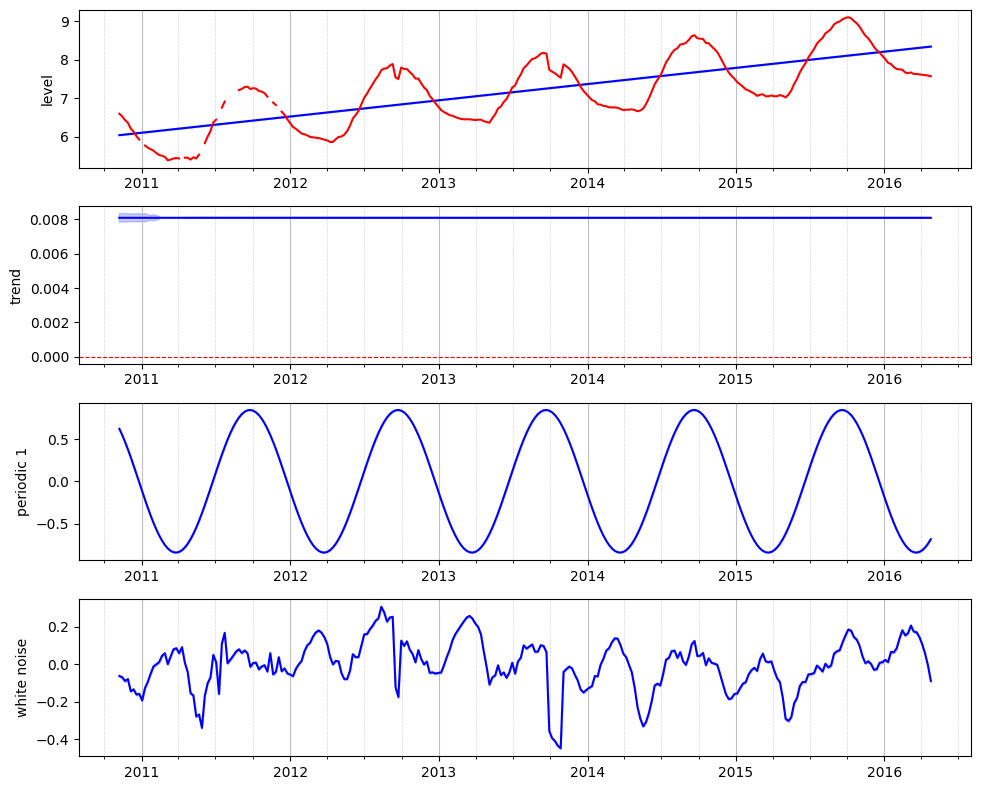

In [12]:
fig, ax =plot_states(data_processor=data_processor,
                     states=states,
                     states_type="smooth",
                     states_to_plot=["level","trend","periodic 1", "white noise"])
plot_data(data_processor=data_processor,
          plot_train_data=True,
          plot_test_data=False,
          plot_validation_data=False,
          sub_plot=ax[0])
plt.show()

Forecast

In [13]:
mu_val_pred, std_val_pred, states=model.forecast(data=validation_data)

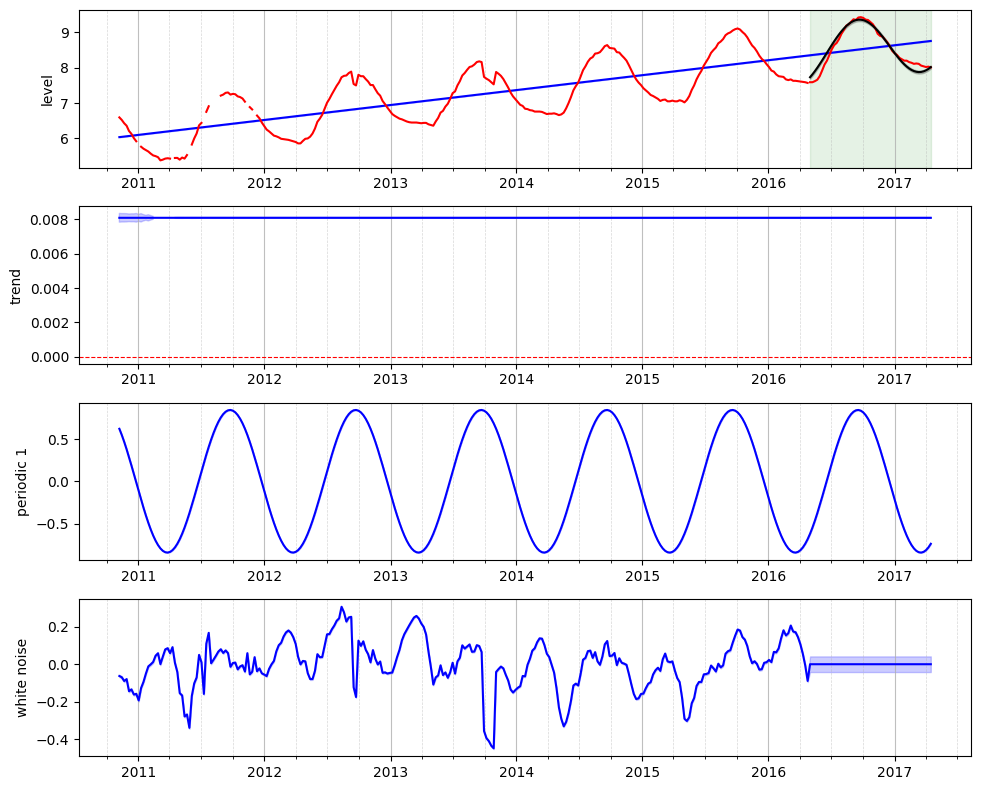

In [14]:
fig, ax =plot_states(data_processor=data_processor,
                     states=states,
                     states_type="smooth",
                     states_to_plot=["level","trend","periodic 1", "white noise"])
plot_data(data_processor=data_processor,
          plot_train_data=True,
          plot_test_data=False,
          plot_validation_data=True,
          sub_plot=ax[0])
plot_prediction(data_processor=data_processor,
                mean_validation_pred=mu_val_pred,
                std_validation_pred = std_val_pred,
                sub_plot=ax[0],
                color="k",
                )
plt.show()